<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_ConvLSTM_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvLSTM Prediction Model

> This notebook is part of the Master Thesis *Predicting Coronal Mass Ejections using Machine Learning methods* by Wilmar Ender, FH Wiener Neustadt, 2023.

This notebook addresses the prediction of CMEs based on a series of input image from the NASA's Solard Dynamics Observatory (SDO) spacecraft. The summarized dicumentation can be found in section. 4.5 in the thesis.

**Objective:** \\
* This notebook aims to perform the prediction of CMEs based on a given sequence of full-disk images from the SDO/AIA dataset.
* apply a ConvLSTM model on the dataset and
* Evaluate the ''reliability'' of such a pure black-box approach in terms of CME prediction.

**Solar event list:** \\
The solar event list is taken from the following paper: \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks* \\
This list/catalog conists of:
* 129 M- and X-class Flares that are associated with CMEs and
* 610 M- and X-class Flares that are **not** associated with CMEs.

**Image Dataset:** \\
The used Image Data is taken from the following paper: \\
*Ahmadzadeh et al. 2019, A Curated Image Parameter Data Set from the Solar Dynamics Observatory Mission*. \\
The data iself is accessed via the so-called *sdo-cli* (https://github.com/i4Ds/sdo-cli) developed by Marius Giger.


> **NOTE**:
> In this current version of the notebook, many code-lines are "commented out".
> Otherwise, when the notebook is started from the beginning every time the data would be downloaded again and unnecessary calculations are performed, slowing down the actual ML model.

## Setting up the Notebook
First, import all necessary libaries and install additional SW.

In [ ]:
# %%capture
# pip install -U sdo-cli

In [2]:
import pandas as pd
import csv
import sys
import numpy as np
import cv2
import os
import shutil
from datetime import datetime
import subprocess
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from google.colab import drive

from keras.utils import plot_model
import tensorflow as tf

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, LSTM,ConvLSTM2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, TimeDistributed, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler

The following code-line flushes the memory and synchronizes it with (in this case) with Google Drive. This is especially, usefull after downloading huge amounts of data.

In [ ]:
# drive.flush_and_unmount()

In [3]:
# mount Google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work


In [5]:
# check content
!ls -a

 00_Dataset		   02_sdo_binclass   04_Tests				        .sdo-cli
 01_sdo_data_exploration   03_sdo_ConvLSTM  'Master Thesis-ML-Project-Checklist.gdoc'


## Helper Functions
Define helper-functions to either speed up the calculation process of for better automation.

In [6]:
def lr_schedule(epoch, learning_rate):
  """
  Learning rate schedule function.

  Parameters:
  - epoch (int): The current epoch number.
  - learning_rate (float): The current learning rate.

  Returns:
  -  float: Updated learning rate based on the specified schedule.
        - If epoch is less than 10, returns the current learning rate.
        - If epoch is greater than or equal to 10, returns the current
          learning rate multiplied by 0.1 (reduced by a factor of 0.1).
  """
  if epoch < 5:
      return learning_rate
  else:
      return learning_rate * 0.1

In [7]:
def classify_and_copy_images(source_dir, positive_dir, negative_dir, event_dataframe):
    """
    Classify and copy images based on timestamps and labels from a DataFrame.

    Parameters:
    - source_dir: Path to the source directory containing images.
    - positive_dir: Path to the directory where positive images will be copied.
    - negative_dir: Path to the directory where negative images will be copied.
    - event_dataframe: DataFrame containing 'Timestamp' and 'Label' columns.

    Returns:
    - copied_files: List of successfully copied filenames.
    - failed_files: List of filenames that couldn't be copied.
    """

    # Ensure destination directories exist
    os.makedirs(positive_dir, exist_ok=True)
    os.makedirs(negative_dir, exist_ok=True)

    copied_files = []
    failed_files = []

    for index, row in event_dataframe.iterrows():
        timestamp_str = row['Timestamp']
        label = row['Label']
        image_filename = timestamp_str + '.jpeg'

        source_path = os.path.join(source_dir, image_filename)

        if os.path.exists(source_path):
            destination_dir = positive_dir if label == 'P' else negative_dir
            destination_path = os.path.join(destination_dir, image_filename)

            try:
                shutil.copy(source_path, destination_path)
                copied_files.append(image_filename)
            except Exception as e:
                print(f"Error copying '{image_filename}': {str(e)}")
                failed_files.append(image_filename)
        else:
            print(f"Image '{image_filename}' not found in the source directory.")

    return copied_files, failed_files

In [10]:
def display_image_series(directory_path, start_image_index, end_image_index):
  """
    Display a series of images from a specified directory, along with timestamps as titles.

    Parameters:
    - directory_path (str): The path to the directory containing image files.
    - start_image_index (int): The index of the first image to be displayed.
    - end_image_index (int): The index of the last image to be displayed.

    The function reads image files from the specified directory, extracts timestamps
    from the filenames, and displays the images in a single row of subplots. The start
    and end indices determine the range of images to display. Timestamps are extracted
    from filenames in the format '%Y-%m-%dT%H%M%S' and displayed as titles below each image.

    Note:
    - Supported image file formats include .png, .jpg, .jpeg, and .gif.
    - Ensure that matplotlib.pyplot (plt) and matplotlib.image (mpimg) are imported.

    Returns:
    - None
    """

  # Get a list of image files in the directory
  image_files = sorted([f for f in os.listdir(directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))])

  # Ensure start and end indices are within bounds
  start_image_index = max(0, start_image_index)
  end_image_index = min(end_image_index, len(image_files) - 1)

  # Create a figure with subplots
  plt.figure(figsize=(20, 10))
  num_images = end_image_index - start_image_index + 1
  fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

  for i in range(start_image_index, end_image_index + 1):
      img_path = os.path.join(directory_path, image_files[i])
      img = mpimg.imread(img_path)

      # Extract timestamp from the filename
      timestamp_str = os.path.splitext(image_files[i])[0]
      timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H%M%S")

      # Display the image
      axes[i - start_image_index].imshow(img)
      axes[i - start_image_index].axis('off')

      # Display the customized title based on the timestamp
      title = timestamp.strftime("%Y-%m-%d %H:%M:%S")
      axes[i - start_image_index].set_title(title, fontsize=12)

  plt.subplots_adjust(wspace=0.1)  # Adjust space between subplots
  plt.show()

In [11]:
def rename_files_in_folder(folder_path):
  """
  Rename files in a specified folder by removing the "__171" substring from their names.

  Parameters:
  - folder_path (str): The path to the directory containing files to be renamed.

  The function iterates through files in the specified directory, identifies files
  containing the "__171" substring in their names, removes this substring, and renames
  the files accordingly. Only files (not directories) are considered for renaming.

  Note:
  - The renaming process involves removing the "__171" substring from the filenames.
  - Check that the provided path is a valid directory before invoking the function.

  Returns:
  - None
  """

    # Check if the provided path is a directory
  if not os.path.isdir(folder_path):
      print(f"{folder_path} is not a directory.")
      return

  # Iterate through files in the directory
  for filename in os.listdir(folder_path):
      old_file_path = os.path.join(folder_path, filename)

      # Check if it's a file (not a directory)
      if os.path.isfile(old_file_path):
          # Split the filename and extension
          base_name, file_extension = os.path.splitext(filename)

          # Check if the filename contains "__171"
          if "__171" in base_name:
              # Remove the "__171" part
              new_base_name = base_name.replace("__171", "")
              new_filename = f"{new_base_name}{file_extension}"
              new_file_path = os.path.join(folder_path, new_filename)

              # Rename the file
              os.rename(old_file_path, new_file_path)
              print(f"Renamed: {filename} to {new_filename}")


In [13]:
def compare_filenames_with_dataframe(directory, dataframe):
  """
  Compare filenames in a directory with timestamps in a DataFrame.

  Parameters:
  - directory (str): The path to the directory containing files to be compared.
  - dataframe (pd.DataFrame): A DataFrame containing timestamps to be compared with filenames.

  Returns:
  - statistics (dict): A dictionary with the following statistics:
      - 'Total Directory Files': Total files in the directory.
      - 'Total DataFrame Names': Total timestamps in the DataFrame.
      - 'Common Files': Number of files with corresponding timestamps.
      - 'Missing Files': Number of timestamps without corresponding files.
      - 'Extra Files': Number of files without corresponding timestamps.
  - df_missing (pd.DataFrame): A DataFrame containing missing timestamps in a more readable format.

  This function compares filenames in the specified directory with timestamps in the given DataFrame.
  It calculates and returns statistics on common, missing, and extra files, along with a DataFrame of missing timestamps.
  """

  file_end = '.jpeg'
  # Get list of filenames from the directory
  directory_filenames = [filename for filename in os.listdir(directory) if filename.endswith(file_end)]

  # Get list of names from the DataFrame
  df_check = dataframe.copy()
  df_check['Timestamp'] = pd.to_datetime(df_check['Timestamp']).dt.strftime('%Y-%m-%dT%H%M%S.jpeg') # Warning! wavelength is now hard coded

  dataframe_names = df_check['Timestamp'].tolist()  # the name of the image should correspond to the timestamp

  # Compare filenames
  common_filenames = set(directory_filenames) & set(dataframe_names)
  missing_filenames = set(dataframe_names) - set(directory_filenames)
  extra_filenames = set(directory_filenames) - set(dataframe_names)

  df_missing = pd.DataFrame (data = missing_filenames,  columns=['Timestamp'])
  df_missing['Timestamp'] = df_missing['Timestamp'].str.replace(r'.jpeg', '', regex=True)
  df_missing['Timestamp'] = pd.to_datetime(df_missing['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')

  # Calculate statistics
  total_directory_files = len(directory_filenames)
  total_dataframe_names = len(dataframe_names)
  total_common_files = len(common_filenames)
  total_missing_files = len(missing_filenames)
  total_extra_files = len(extra_filenames)
  print('Total Directory Files: ', total_directory_files)
  print('Total DataFrame Names: ', total_dataframe_names)
  print('Common Files: ', total_common_files)
  print('Missing Files: ', total_missing_files)
  print('Extra Files: ', total_extra_files)

  statistics = {
      'Total Directory Files': total_directory_files,
      'Total DataFrame Names': total_dataframe_names,
      'Common Files': total_common_files,
      'Missing Files': total_missing_files,
      'Extra Files': total_extra_files,
      #'Common File Names': common_filenames,
      'Missing File Names': missing_filenames,
      'Extra File Names': extra_filenames
  }

  return statistics, df_missing

In [15]:
def create_csv_from_directory(dataframe, directory_path, output_csv_path):
  """
  Create a CSV file containing timestamp-label pairs based on files in a directory.

  Parameters:
  - dataframe (pd.DataFrame): The DataFrame containing timestamp-label information.
  - directory_path (str): The path to the directory containing files with timestamps.
  - output_csv_path (str): The path to save the resulting CSV file.

  The function traverses the specified directory and its subfolders, extracts timestamps
  from file names, matches them with labels in the provided DataFrame, and creates a new
  DataFrame with timestamp-label pairs. The resulting DataFrame is then saved as a CSV file.

  Note:
  - Ensure the DataFrame contains a 'Timestamp' column in the format '%Y-%m-%dT%H:%M:%S'.
  - Timestamps are extracted from filenames, and invalid formats are handled gracefully.
  - The resulting CSV file is sorted by timestamp in ascending order.

  Returns:
  - None
  """
  # Initialize an empty list to store timestamp-label pairs
  timestamp_label_pairs = []

  # Use os.walk to recursively traverse the directory and its subfolders
  for root, _, files in os.walk(directory_path):
      for file_name in files:
          # Extract the timestamp from the file name
          parts = file_name.split('T')
          if len(parts) == 2:
              file_timestamp_str = parts[0] + 'T' + parts[1].split('.')[0]
          else:
              # Handle invalid file name format
              continue

          try:
              # Convert the file timestamp string to a datetime object
              file_timestamp = datetime.strptime(file_timestamp_str, '%Y-%m-%dT%H%M%S')
          except ValueError:
              # Handle invalid timestamp format
              continue

          # Find the corresponding row in the DataFrame based on the timestamp
          matching_row = dataframe[dataframe['Timestamp'] == file_timestamp.strftime('%Y-%m-%dT%H:%M:%S')]

          if not matching_row.empty:
              # Get the label from the matching row
              label = matching_row.iloc[0]['Label']

              # Append the timestamp-label pair to the list
              timestamp_label_pairs.append((file_timestamp_str, label))

  # Create a new DataFrame from the list of timestamp-label pairs
  result_df = pd.DataFrame(timestamp_label_pairs, columns=['Timestamp', 'Label'])
  result_df = result_df.sort_values(by='Timestamp', ascending = True)
  # Save the DataFrame to a CSV file
  result_df.to_csv(output_csv_path, index=False)

In [16]:
def copy_last_n_images(source_directory, destination_directory, n=None):
  """
  Copy the last n images from a source directory to a destination directory.

  Parameters:
  - source_directory (str): The path to the source directory containing image files.
  - destination_directory (str): The path to the destination directory for copied images.
  - n (int or None): The number of last images to copy. If None, all images are copied.

  The function retrieves a list of files from the source directory, ensures the existence
  of the destination directory, and copies the last n files (or all files if n is None)
  from the source to the destination.

  Note:
  - The function uses os.listdir to obtain a list of files, which are assumed to be image files.
  - The destination directory is created if it does not exist.
  - If n is None, all files are copied.

  Returns:
  - None
  """
  # Get a list of files in the source directory
  files = sorted(os.listdir(source_directory))

  # Ensure the destination directory exists
  os.makedirs(destination_directory, exist_ok=True)

  # Copy the last n files, or all files if n is None
  files_to_copy = files[-n:] if n is not None else files

  for file_name in files_to_copy:
      source_path = os.path.join(source_directory, file_name)
      destination_path = os.path.join(destination_directory, file_name)
      shutil.copy2(source_path, destination_path)

In [17]:
def copy_images_between_indices(source_directory, destination_directory, start_index, end_index):
  """
  Copy image files from a source directory to a destination directory within a specified index range.

  Parameters:
  - source_directory (str): The path to the source directory containing image files.
  - destination_directory (str): The path to the destination directory for copied images.
  - start_index (int): The index of the first image to copy.
  - end_index (int): The index of the last image to copy.

  The function retrieves a list of files from the source directory, ensures the existence
  of the destination directory, and copies image files within the specified index range
  (inclusive) from the source to the destination.

  Note:
  - The function assumes that the files in the source directory are image files.
  - The destination directory is created if it does not exist.
  - Start and end indices are clamped to be within the bounds of the available files.

  Returns:
  - None
  """
  # Get a list of files in the source directory
  files = sorted(os.listdir(source_directory))

  # Ensure the destination directory exists
  os.makedirs(destination_directory, exist_ok=True)

  # Ensure start_index and end_index are within bounds
  start_index = max(0, start_index)
  end_index = min(end_index, len(files) - 1)

  # Copy the files between start_index and end_index (inclusive)
  files_to_copy = files[start_index:end_index + 1]

  for file_name in files_to_copy:
      source_path = os.path.join(source_directory, file_name)
      destination_path = os.path.join(destination_directory, file_name)
      shutil.copy2(source_path, destination_path)


In [19]:
def resize_images(source_dir, target_dir):
  """
  Resize JPEG images from a source directory and save the resized images to a target directory.

  Parameters:
  - source_dir (str): The path to the source directory containing JPEG images to be resized.
  - target_dir (str): The path to the target directory for saving the resized images.
  - new_width (int): The new width in pixels for the resized images.
  - new_height (int): The new height in pixels for the resized images.

  The function iterates through JPEG images in the source directory, resizes each image
  to the specified dimensions using the ANTIALIAS algorithm, and saves the resized images
  to the target directory.

  Note:
  - The function assumes that the images in the source directory are in JPEG format.
  - Ensure that the source and target directories exist before invoking the function.

  Returns:
  - None
  """
  # Function to resize images
  with tqdm(total=len(os.listdir(source_dir)), desc=f"Resizing {source_dir} images") as pbar:
      for filename in os.listdir(source_dir):
          if filename.endswith('.jpeg'):
              source_path = os.path.join(source_dir, filename)
              target_path = os.path.join(target_dir, filename)
              # Open the image and resize it
              img = Image.open(source_path)
              img = img.resize((new_width, new_height), Image.ANTIALIAS)
              img.save(target_path)
              pbar.update(1)

In [20]:
def normalize_images(source_dir, target_dir, dataset_type):
  """
  Normalize JPEG images from 0 to 255 and save them to a target directory with a progress bar.

  Parameters:
  - source_dir (str): The path to the source directory containing JPEG images to be normalized.
  - target_dir (str): The path to the target directory for saving the normalized images.
  - dataset_type (str): A string indicating the type of dataset being normalized (e.g., 'train', 'test').

  The function iterates through JPEG images in the source directory, loads each image using OpenCV,
  normalizes the pixel values from 0 to 255 using cv2.normalize, and saves the normalized images
  to the target directory. A tqdm progress bar is displayed during the normalization process.

  Note:
  - The function assumes that the images in the source directory are in JPEG format.
  - Ensure that the source and target directories exist before invoking the function.

  Returns:
  - None
  """
  # Function to normalize images from 0 to 255 with a progress bar (no print messages)
  images = os.listdir(source_dir)
  with tqdm(total=len(images), desc=f"Normalizing {dataset_type} images", unit="image", dynamic_ncols=True) as pbar:
      for filename in images:
          if filename.endswith('.jpeg'):
              source_path = os.path.join(source_dir, filename)
              target_path = os.path.join(target_dir, filename)

              # Load the image
              img = cv2.imread(source_path)

              # Normalize the image from 0 to 255
              normalized_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

              # Save the normalized image
              cv2.imwrite(target_path, normalized_img)

              # Update progress bar
              pbar.update(1)

In [22]:
def classify_images(source_dir, positive_dir, negative_dir):
  """
  Classify and move JPEG images based on timestamps within event ranges.

  Parameters:
  - source_dir (str): The path to the source directory containing JPEG images to be classified.
  - positive_dir (str): The path to the directory for images classified as positive.
  - negative_dir (str): The path to the directory for images classified as negative.
  - df_cme_list (pd.DataFrame): DataFrame containing event ranges with 'Start Time', 'End Time',
    and 'CME' columns.

  The function iterates through JPEG images in the source directory, extracts timestamps from
  filenames, and checks if each timestamp falls within any event range in the 'df_cme_list'.
  Images are then classified and moved accordingly to the positive or negative directory.

  Note:
  - The function assumes that the images in the source directory are in JPEG format.
  - The 'df_cme_list' DataFrame should have columns 'Start Time', 'End Time', and 'CME'.
  - Ensure that the source, positive, and negative directories exist before invoking the function.

  Returns:
  - None
  """
  # Function to classify and move images based on timestamps within event ranges training
  for filename in os.listdir(source_dir):
      if filename.endswith('.jpeg'):
          timestamp = filename[:-5]  # Extract timestamp from the filename (remove '.jpeg' extension)
          # Check if the timestamp is within any event range in the 'cme_events' DataFrame
          for _, event in df_cme_list.iterrows():
              if(event['CME']!="no"):
                start_time = event['Start Time']  # Replace 'start_time' with the actual column name
                end_time = event['End Time']  # Replace 'end_time' with the actual column name
                if start_time <= timestamp <= end_time:
                    # Move to the positive folder
                    shutil.copy2(os.path.join(source_dir, filename), os.path.join(positive_dir, filename))
                    break  # Move to the next image
          else:
              # If the timestamp does not fall within any event range, move to the negative folder
              shutil.copy2(os.path.join(source_dir, filename), os.path.join(negative_dir, filename))

In [23]:
def classify_and_move_images(source_dir, positive_dir, negative_dir):
  """
  Classify and move JPEG images based on timestamps within event ranges.

  Parameters:
  - source_dir (str): The path to the source directory containing JPEG images to be classified.
  - positive_dir (str): The path to the directory for images classified as positive.
  - negative_dir (str): The path to the directory for images classified as negative.
  - df_cme_list (pd.DataFrame): DataFrame containing event ranges with 'Start Time', 'End Time',
    and 'CME' columns.

  The function iterates through JPEG images in the source directory, extracts timestamps from
  filenames, and checks if each timestamp falls within any event range in the 'df_cme_list'.
  Images are then classified and moved accordingly to the positive or negative directory.

  Note:
  - The function assumes that the images in the source directory are in JPEG format.
  - The 'df_cme_list' DataFrame should have columns 'Start Time', 'End Time', and 'CME'.
  - Ensure that the source, positive, and negative directories exist before invoking the function.

  Returns:
  - None
  """
  # Function to classify and move images based on timestamps within event ranges training
  for filename in os.listdir(source_dir):
      if filename.endswith('.jpeg'):
          timestamp = filename[:-5]  # Extract timestamp from the filename (remove '.jpeg' extension)
          # Check if the timestamp is within any event range in the 'cme_events' DataFrame
          for _, event in df_cme_list.iterrows():
              if(event['CME']!="no"):
                start_time = event['Start Time']  # Replace 'start_time' with the actual column name
                end_time = event['End Time']  # Replace 'end_time' with the actual column name
                if start_time <= timestamp <= end_time:
                    # Move to the positive folder
                    shutil.move(os.path.join(source_dir, filename), os.path.join(positive_dir, filename))
                    break  # Move to the next image
          else:
              # If the timestamp does not fall within any event range, move to the negative folder
              shutil.move(os.path.join(source_dir, filename), os.path.join(negative_dir, filename))

In [ ]:
# def delete_files_with_pattern(directory, pattern):
#     # Recursively traverse the directory tree
#     for root, _, files in os.walk(directory):
#         for filename in files:
#             if filename.endswith(pattern):
#                 file_path = os.path.join(root, filename)
#                 try:
#                     os.remove(file_path)
#                     print(f"Deleted: {file_path}")
#                 except Exception as e:
#                     print(f"Failed to delete {file_path}: {str(e)}")

In [25]:
def load_and_preprocess_images_with_time(directory, image_size):
  """
  Load and preprocess images from a specified directory with timestamps and labels.

  Parameters:
  - directory (str): The path to the main directory containing 'pos' and 'neg' subdirectories.
  - image_size (tuple): A tuple representing the target size of the images (width, height).

  The function iterates through 'pos' and 'neg' subdirectories in the specified main directory,
  reads and resizes images, normalizes pixel values to [0, 1], and extracts timestamps from filenames.
  Positive examples have filenames containing "pos," and negative examples have filenames containing "neg."

  Note:
  - The function assumes that the images in 'pos' and 'neg' subdirectories are in JPEG format.
  - The filenames are expected to contain timestamps in the format '%Y-%m-%dT%H%M%S'.
  - Positive examples have filenames containing "pos," and negative examples have filenames containing "neg."
  - The labels are encoded as 1 for positive examples and 0 for negative examples.

  Returns:
  - images (np.ndarray): A 4D numpy array containing preprocessed images.
  - labels (np.ndarray): A 1D numpy array containing corresponding labels (1 for positive, 0 for negative).
  - timestamps (np.ndarray): A 1D numpy array containing timestamps extracted from filenames.
  """
  images = []
  labels = []
  timestamps = []  # To store timestamps extracted from filenames

  for dirname in ['pos', 'neg']: #os.listdir(directory):
      for filename in os.listdir(os.path.join(directory, dirname)):
          if filename.endswith('.jpeg'):
              image_path = os.path.join(directory, dirname, filename)
              image = cv2.imread(image_path)
              image = cv2.resize(image, image_size)
              image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]

              images.append(image)

              # Extract timestamp from the filename
              timestamp_str = filename[:-5]  # Remove '.jpeg' extension
              timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H%M%S")
              timestamps.append(timestamp)

              # Assuming that positive examples have filenames containing "pos" and negative examples "neg"
              if "pos" in dirname:
                  labels.append(1)  # Positive example
              elif "neg" in dirname:
                  labels.append(0)  # Negative example

  return np.array(images), np.array(labels), np.array(timestamps)

In [26]:
def display_image_sequences(X_test, y_test, num_sequences=5, num_series=5):
  """
  Display image sequences along with labels for visualization.

  Parameters:
  - X_test (np.ndarray): A 4D numpy array representing image sequences (batch_size, sequence_length, width, height).
  - y_test (np.ndarray): A 1D numpy array representing labels for each image sequence.
  - num_sequences (int): The number of sequences to display in each series.
  - num_series (int): The number of series (batch_size) to display.

  The function creates a series of plots to display image sequences with associated labels.
  Each series displays a specified number of sequences, and each sequence shows individual frames
  along with their corresponding filenames and labels.

  Note:
  - The function assumes that the images in 'X_test' are in the format (batch_size, sequence_length, width, height).
  - The labels in 'y_test' correspond to the entire image sequences.
  - The number of displayed sequences and series can be adjusted using the 'num_sequences' and 'num_series' parameters.

  Returns:
  - None
  """
  for i in range(num_series):
      plt.figure(figsize=(20, 10))
      # Display each sequence
      for j in range(num_sequences):
          plt.subplot(1, num_sequences, j + 1)

          # Display the image with filename
          filename = f"Frame {j+1}"
          plt.imshow(X_test[i, j])
          plt.title(filename)
          plt.axis('off')

          # Display the label for each frame
          plt.text(0, -0.1, f"Label: {y_test[i]}", transform=plt.gca().transAxes)

      plt.show()

In [27]:
def has_duplicates(images):
  """
  Check if there are duplicate images in a given array.

  Parameters:
  - images (np.ndarray): A 4D numpy array representing images (batch_size, width, height, channels).

  Note:
  - The function assumes that the images are represented as a 4D numpy array.
  - The uniqueness is determined based on the flattened representation of each image.

  Returns:
  - has_duplicates (bool): True if duplicates are found, False otherwise.
  - duplicate_indices (np.ndarray): Indices of duplicate images.
  """

  flattened_images = images.reshape(images.shape[0], -1)
  unique_hashes, unique_indices = np.unique(flattened_images, axis=0, return_index=True)
  duplicate_indices = np.setdiff1d(np.arange(flattened_images.shape[0]), unique_indices)
  return len(duplicate_indices) > 0, duplicate_indices

## Load Event-Lists
The following list (stored as a csv file) from *Liu et al. 2020* holds all the events and non-events presented in the study.

First, the csv files are imported and stored as a pandas dataframes.
All lists are taken from *Liu et al. 2020*.

These lists include:
* a base/initail event list, which holds all the events and non-events
* a sampled training list with a 12 min intervall between the samples
* a sampled testing list also with a 12 min interval




**Base Event List**

The follwoing initial list holds all events and non-events from the study.

In [35]:
# load list with both (neg, pos) labels
df_cme_list = pd.read_csv(r'00_Dataset/event_lists/all_cme_events.csv', delimiter =';')

# convert time stamp such that sdo-cli can read them
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13:00,2010-05-05T17:19:00,2010-05-05T17:22:00,11069,8,No
1,M1.0,2010-06-13T05:30:00,2010-06-13T05:39:00,2010-06-13T05:44:00,11079,49,No
2,M2.0,2010-06-12T00:30:00,2010-06-12T00:57:00,2010-06-12T01:02:00,11081,54,No
3,M1.0,2010-08-07T17:55:00,2010-08-07T18:24:00,2010-08-07T18:47:00,11093,115,No
4,M2.9,2010-10-16T19:07:00,2010-10-16T19:12:00,2010-10-16T19:15:00,11112,211,No


The next lists are divided into a testing and training list. These list contain the above lists. In particular, the training list contain the samples from the years 2010-2014, while the testing list holds the samples from the yeas 2015-2019. Hence the lists and following datsets are disjoint. Furtermore, the events were sampled for predicting CMEs within the next x hours (x = 12, 24, 36, 48 or 60). In the present case x = 12 hours.

These lists hold the following infromation:

> N means there is a >=M class flare within the next x hours but this flare is not associated with a CME. \\
> P means there is a >=M class flare within the next x hours and this flare is associated with a CME. \\
> The second column holds the Timestamp of the sample. \\
> The third column and fourth column are titled NOAA active region number and HARP number, respectively. \\
> Starting from the fifth column, you can see physical parameters of data samples, which include 18 SHARP parameters:
TOTUSJH, TOTPOT, TOTUSJZ, ABSNJZH, SAVNCPP, USFLUX, AREA_ACR, MEANPOT, R_VALUE, SHRGT45, MEANGAM, MEANJZH, MEANGBT, MEANGBZ, MEANJZD, MEANGBH, MEANSHR, MEANALP.

**Training List**


In [36]:
# load list with both (neg, pos) labels of training list for t= 12 h prediction window
df_cme_training_12 = pd.read_csv(r'00_Dataset/event_lists/Liu2020_CME_data_samples/normalized_training_12.csv', delimiter =',')
print('The training list contains ', df_cme_training_12.shape[0], 'samples')

The training list contains  20347 samples


In [37]:
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2010-05-05T05:22:22.90Z,11069,8,-0.5461,-0.5672,-0.6696,0.3159,0.2083,-0.7610,...,0.3751,-0.4109,-0.1049,-3.3554,0.5327,0.6921,-0.1673,0.5768,-0.1024,-1.1464
1,N,2010-05-05T05:34:22.90Z,11069,8,-0.5438,-0.5635,-0.6607,0.3360,0.2741,-0.7552,...,0.3969,-0.3188,-0.0283,-3.2984,0.4808,0.6302,-0.0497,0.5683,-0.0324,-1.1596
2,N,2010-05-05T05:46:22.90Z,11069,8,-0.5469,-0.5604,-0.6521,0.3315,0.3650,-0.7518,...,0.3961,-0.2149,0.0489,-3.1799,0.4268,0.5787,-0.1523,0.5588,0.0503,-1.1509
3,N,2010-05-05T06:22:22.90Z,11069,8,-0.5275,-0.5546,-0.6356,0.3042,0.2075,-0.7346,...,0.3842,-0.2724,0.0144,-2.9791,0.4130,0.5345,-0.0549,0.5549,0.0166,-1.0816
4,N,2010-05-05T06:34:22.90Z,11069,8,-0.5212,-0.5481,-0.6294,0.3653,0.2579,-0.7322,...,0.3554,-0.2530,0.0585,-3.1240,0.4596,0.6073,0.1217,0.5626,0.0660,-1.1460


In [38]:
# reduce dataframe to relevant columns, i.e. remove EM/Plasma parameters
df_cme_training_12 = df_cme_training_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)


Convert the time stamps such that sdo.cli can read them.

In [39]:
df_cme_training_12['Timestamp'] = pd.to_datetime(df_cme_training_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2010-05-05T05:22:22,11069,8
1,N,2010-05-05T05:34:22,11069,8
2,N,2010-05-05T05:46:22,11069,8
3,N,2010-05-05T06:22:22,11069,8
4,N,2010-05-05T06:34:22,11069,8


In [40]:
# df_cme_training_12 = df_cme_training_12.tail(df_cme_training_12.shape[0] -282)
# df_cme_training_12

In [41]:
# get negative samples
df_cme_training_12_neg = df_cme_training_12.loc[df_cme_training_12['Label'] == 'N']
df_cme_training_12_neg = df_cme_training_12_neg.reset_index(drop=True)
print('There are', df_cme_training_12_neg.shape[0], 'negative samples in the training set.\n')
df_cme_training_12_neg.tail()

There are 16960 negative samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
16955,N,2016-01-01T21:22:08,12473,6206
16956,N,2016-01-01T21:34:08,12473,6206
16957,N,2016-01-01T21:46:08,12473,6206
16958,N,2016-01-01T21:58:08,12473,6206
16959,N,2016-01-01T22:22:08,12473,6206


In [42]:
# get positive samples
df_cme_training_12_pos = df_cme_training_12.loc[df_cme_training_12['Label'] == 'P']
df_cme_training_12_pos = df_cme_training_12_pos.reset_index(drop = True)
print('There are', df_cme_training_12_pos.shape[0], 'positive samples in the training set.\n')
df_cme_training_12_pos.tail()

There are 3387 positive samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
3382,P,2015-12-28T11:46:08,12473,6206
3383,P,2015-12-28T11:58:08,12473,6206
3384,P,2015-12-28T12:10:08,12473,6206
3385,P,2015-12-28T12:22:08,12473,6206
3386,P,2015-12-28T12:34:08,12473,6206


Now, the same for the testing list.

**Testing List**

In [43]:
# load list with both (neg, pos) labels of testing list for t= 12 h
df_cme_test_12 = pd.read_csv(r'00_Dataset/event_lists/Liu2020_CME_data_samples/normalized_testing_12.csv', delimiter =',')
# df_cme_test_12.head()

In [44]:
# reduce dataframe to relevant columns
df_cme_test_12 = df_cme_test_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)
df_cme_test_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2016-02-11T22:58:09.90Z,12497,6327
1,N,2016-02-11T23:10:09.90Z,12497,6327
2,N,2016-02-11T23:22:09.90Z,12497,6327
3,N,2016-02-11T23:34:10.00Z,12497,6327
4,N,2016-02-11T23:46:10.00Z,12497,6327


In [45]:
# convert time stamp
# convert time stamp such that sdo-cli can read them
df_cme_test_12['Timestamp'] = pd.to_datetime(df_cme_test_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_test_12.tail()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
1307,N,2017-09-08T21:46:41,12673,7115
1308,N,2017-09-08T21:58:41,12673,7115
1309,N,2017-09-08T22:10:41,12673,7115
1310,N,2017-09-08T22:22:41,12673,7115
1311,N,2017-09-08T22:34:41,12673,7115


In [46]:
df_cme_test_12_neg = df_cme_test_12.loc[df_cme_test_12['Label'] == 'N']
df_cme_test_12_neg = df_cme_test_12_neg.reset_index(drop=True)
print('There are', df_cme_test_12_neg.shape[0], 'negative samples in the test set.\n')
df_cme_test_12_neg.tail()

There are 762 negative samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
757,N,2017-09-08T21:46:41,12673,7115
758,N,2017-09-08T21:58:41,12673,7115
759,N,2017-09-08T22:10:41,12673,7115
760,N,2017-09-08T22:22:41,12673,7115
761,N,2017-09-08T22:34:41,12673,7115


In [47]:
df_cme_test_12_pos = df_cme_test_12.loc[df_cme_test_12['Label'] == 'P']
df_cme_test_12_pos = df_cme_test_12_pos.reset_index(drop=True)
print('There are', df_cme_test_12_pos.shape[0], 'positive samples in the test set.\n')
df_cme_test_12_pos.tail()

There are 550 positive samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
545,P,2017-09-08T05:10:41,12673,7115
546,P,2017-09-08T05:22:41,12673,7115
547,P,2017-09-08T05:34:41,12673,7115
548,P,2017-09-08T05:46:41,12673,7115
549,P,2017-09-08T06:10:41,12673,7115


In [48]:
# Usage
# folder_path = '00_Dataset/Liu2020_sampled/test_12/pos/'  # Replace with your Google Drive folder path
# rename_files_in_folder(folder_path)

By now we have four event lists from the sampled dataset:


*   df_cme_test_12_neg >> 762
*   df_cme_test_12_pos >> 550
*   df_cme_training_12_neg >> 16678
*   df_cme_training_12_pos >> 3387 samples


## Download and Explore the Image-Data
After importing and exploring the relevant lists, all images were tried to download.
> **Note:** most of the below code lines are commented out. Otherweise, we would start downloading the images everytime we start the notebook.

**Training**

Download the negative-class training samples.

In [ ]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/train/neg/', start_idx=0,  event_list = df_cme_training_12_neg, dt = '10min', wavelength = '171')

After downloading the samples, we check them in terms of completeness:

In [53]:
directory_path_training_12_neg = '00_Dataset/Liu2020_sampled/training/neg/'
result_training_12_neg, missing_files_training_neg = compare_filenames_with_dataframe(directory_path_training_12_neg, df_cme_training_12_neg)

Total Directory Files:  15361
Total DataFrame Names:  16960
Common Files:  15361
Missing Files:  778
Extra Files:  0


In [54]:
result_training_12_neg['Common Files']

15361

As one can observe almost 500 images/samples couldn't be downloaded!

Next, we try to download the positive training samples

In [ ]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/train/pos/', start_idx=0, event_list = df_cme_training_12_pos, dt = '10min', wavelength = '171')

Again, lets check the missing files:

In [55]:
directory_path_training_12_pos = '00_Dataset/Liu2020_sampled/training/pos/'
result_training_12_pos, missing_files_training_pos = compare_filenames_with_dataframe(directory_path_training_12_pos, df_cme_training_12_pos)

Total Directory Files:  3144
Total DataFrame Names:  3387
Common Files:  3144
Missing Files:  113
Extra Files:  0


In [56]:
total_training_files = result_training_12_pos['Common Files'] + result_training_12_neg['Common Files']
print('There are in total', total_training_files, 'training files.')

There are in total 18505 training files.


**Testing**

Same for the negative samples for testing:

In [57]:
#create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/neg/', start_idx=0, event_list = df_cme_test_12_neg, dt = '10min', wavelength = '171')

In [58]:
directory_path_test_12_neg = '00_Dataset/Liu2020_sampled/testing/neg/'
result_test_12_neg, missing_files_test_neg = compare_filenames_with_dataframe(directory_path_test_12_neg, df_cme_test_12_neg)

Total Directory Files:  739
Total DataFrame Names:  762
Common Files:  739
Missing Files:  23
Extra Files:  0


...and for the positive samples:

In [ ]:
#create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/pos/', start_idx= 0, event_list = df_cme_test_12_pos, dt = '10min', wavelength = '171')

In [59]:
directory_path_test_12_pos = '00_Dataset/Liu2020_sampled/testing/pos/'
result_test_12_pos, missing_test_pos = compare_filenames_with_dataframe(directory_path_test_12_pos, df_cme_test_12_pos)

Total Directory Files:  550
Total DataFrame Names:  550
Common Files:  549
Missing Files:  1
Extra Files:  1


In [60]:
total_testing_files = result_test_12_neg['Common Files'] + result_test_12_pos['Common Files']
print('There are ', total_testing_files, ' total testing files' )

There are  1288  total testing files


**Update Event Lists**

Since not all data samples could be downloaded, the event lists have to be adjusted acordingly.

In [64]:
train_dir_path = '00_Dataset/Liu2020_sampled/training'
output_train_csv_path = '00_Dataset/Liu2020_sampled/training/train_label.csv'

#create_csv_from_directory(df_cme_training_12, train_dir_path , output_train_csv_path)
train_label_csv = pd.read_csv(r'00_Dataset/Liu2020_sampled/training/train_label.csv', delimiter =',')
train_label_csv

,Timestamp,Label
0,2011-03-25T114617,N
1,2011-03-25T115817,N
2,2011-03-25T121017,N
3,2011-03-25T122217,N
4,2011-03-25T123417,N
...,...,...
18500,2015-02-09T142210,P
18501,2015-02-09T143410,P
18502,2015-02-09T144610,P
18503,2015-02-09T145810,P


In [65]:
test_dir_path = '00_Dataset/Liu2020_sampled/testing'
output_test_csv_path = '00_Dataset/Liu2020_sampled/testing/test_label.csv'

#create_csv_from_directory(df_cme_test_12, test_dir_path, output_test_csv_path)
test_label_csv = pd.read_csv(r'00_Dataset/Liu2020_sampled/testing/test_label.csv', delimiter =',')
test_label_csv

,Timestamp,Label
0,2016-02-11T225809,N
1,2016-02-11T225809,N
2,2016-02-11T231009,N
3,2016-02-11T231009,N
4,2016-02-11T232209,N
...,...,...
2571,2017-09-08T221041,N
2572,2017-09-08T222241,N
2573,2017-09-08T222241,N
2574,2017-09-08T223441,N


**Summary:**
* Out of the possible 20347 training files, XXX could be downloaded.
* Out of the possible 20347 testing files, XXX could be downloaded.
* in detail, this results in the following split:
  * Training:
    * positive:
    * negative:
  * Testing:
    * positive:
    * negative:

## Make a reduced Dataset
Due to computational constraints, based on the downloaded data a reduced dataset was created.

**Training:**

In [66]:
working_dir = './03_sdo_ConvLSTM/'

In [67]:
source_directory_training = '00_Dataset/Liu2020_sampled/training/all'
target_directory_training =  working_dir + 'reduced_dataset/training'

# Define the desired number of last images to copy, or set to None to copy all files
n = 3000

#copy_last_n_images(source_directory_training, target_directory_training, n)

Again, create an updated event-list for the reduced dataset:
Training:

In [68]:
output_train_csv_path =  working_dir + 'reduced_dataset/training/training_label.csv'

In [ ]:
# create_csv_from_directory(df_cme_training_12, target_directory_training , output_train_csv_path)

In [69]:
training_reduced = pd.read_csv(output_train_csv_path, delimiter =',')
training_reduced #.head()

,Timestamp,Label
0,2015-02-03T222210,N
1,2015-02-03T223410,N
2,2015-02-03T224610,N
3,2015-02-03T225810,N
4,2015-02-03T231010,N
...,...,...
2995,2016-01-01T212208,N
2996,2016-01-01T213408,N
2997,2016-01-01T214608,N
2998,2016-01-01T215808,N


In [70]:
training_reduced_neg = training_reduced.loc[training_reduced['Label'] == 'N'].sort_values(by='Timestamp', ascending = True)
#training_reduced_neg

In [71]:
training_reduced_pos = training_reduced.loc[training_reduced['Label'] == 'P'].sort_values(by='Timestamp', ascending = True)
#training_reduced_pos

Testing:

In [121]:
source_directory_testing = '00_Dataset/Liu2020_sampled/testing/all'
target_directory_testing =  working_dir + 'reduced_dataset/testing'

# Define the desired number of last images to copy, or set to None to copy all files
n = 401

# copy_last_n_images(source_directory_testing, target_directory_testing, n)

In [122]:
output_test_csv_path =  working_dir + 'reduced_dataset/testing/test_label.csv'

In [123]:
create_csv_from_directory(df_cme_test_12, target_directory_testing, output_test_csv_path)

In [124]:
testing_reduced = pd.read_csv(output_test_csv_path, delimiter =',')
testing_reduced

,Timestamp,Label
0,2017-09-04T215842,N
1,2017-09-04T221042,N
2,2017-09-04T222242,N
3,2017-09-04T223442,N
4,2017-09-04T224642,N
...,...,...
395,2017-09-08T214641,N
396,2017-09-08T215841,N
397,2017-09-08T221041,N
398,2017-09-08T222241,N


In [125]:
testing_reduced_pos = testing_reduced.loc[testing_reduced['Label'] == 'P'].sort_values(by='Timestamp', ascending = True)
#testing_reduced_pos

In [126]:
testing_reduced_neg = testing_reduced.loc[testing_reduced['Label'] == 'N'].sort_values(by='Timestamp', ascending = True)
#testing_reduced_neg

Validation:

In [133]:
source_directory_validation = source_directory_testing
target_directory_validation =  working_dir + 'reduced_dataset/validation'

# Define the desired number of last images to copy, or set to None to copy all files
n = 399

# copy_images_between_indices(source_directory_validation, target_directory_validation, 0, n)

In [134]:
output_val_csv_path =  working_dir + 'reduced_dataset/validation/val_label.csv'

In [135]:
create_csv_from_directory(df_cme_test_12, target_directory_validation, output_val_csv_path)

In [136]:
validation_reduced = pd.read_csv(output_val_csv_path, delimiter =',')
validation_reduced

,Timestamp,Label
0,2016-02-11T225809,N
1,2016-02-11T231009,N
2,2016-02-11T232209,N
3,2016-02-11T233410,N
4,2016-02-11T234610,N
...,...,...
395,2016-11-29T081032,N
396,2016-11-29T082232,N
397,2016-11-29T083432,N
398,2016-11-29T084632,N


In [137]:
validation_reduced_pos = validation_reduced.loc[validation_reduced['Label'] == 'P'].sort_values(by='Timestamp', ascending = True)
#validation_reduced_pos

In [138]:
validation_reduced_neg = validation_reduced.loc[validation_reduced['Label'] == 'N'].sort_values(by='Timestamp', ascending = True)
#validation_reduced_neg

Display dataset characteristics:

In [139]:
# show number of samples of the reduced training list
print('There are', training_reduced.shape[0], 'samples stored in the TRANING-list.')
print('With ', training_reduced.loc[training_reduced['Label'] == 'N'].shape[0], ' negative samples')
print('and ', training_reduced.loc[training_reduced['Label'] == 'P'].shape[0], ' positive samples')

There are 3000 samples stored in the TRANING-list.
With  2186  negative samples
and  814  positive samples


In [140]:
# show number of samples of the reduced testing list
print('There are', testing_reduced.shape[0], 'samples stored in the TEST-list.')
print('With ', testing_reduced.loc[testing_reduced['Label'] == 'N'].shape[0], ' negative samples')
print('and ', testing_reduced.loc[testing_reduced['Label'] == 'P'].shape[0], ' positive samples')

There are 400 samples stored in the TEST-list.
With  211  negative samples
and  189  positive samples


In [141]:
# show number of samples of the validation list
print('There are', validation_reduced.shape[0], 'samples stored in the VALIDATION-list.')
print('With ', validation_reduced.loc[validation_reduced['Label'] == 'N'].shape[0], ' negative samples')
print('and ', validation_reduced.loc[validation_reduced['Label'] == 'P'].shape[0], ' positive samples')

There are 400 samples stored in the VALIDATION-list.
With  303  negative samples
and  97  positive samples


## Display a Sample Image-Series

<Figure size 2000x1000 with 0 Axes>

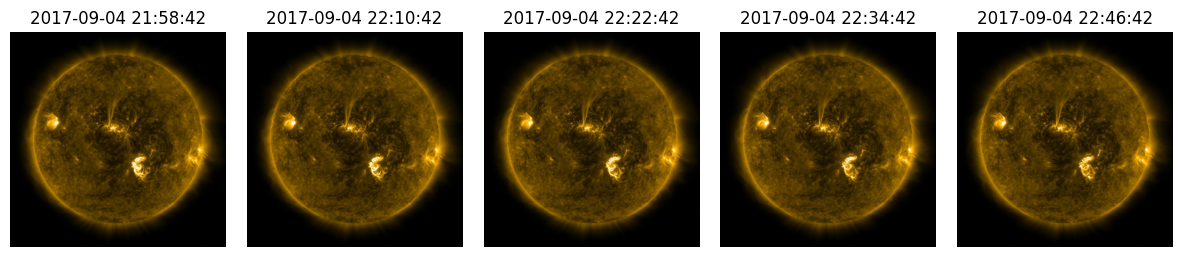

In [142]:
# Define with the desired start and end index
start_index = 0
end_index = 4

display_image_series(target_directory_testing, start_index, end_index)

<Figure size 2000x1000 with 0 Axes>

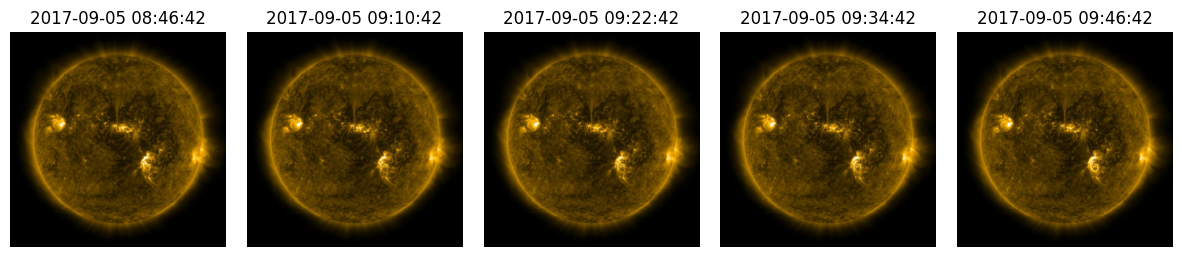

In [143]:
display_image_series(target_directory_testing, 41, 45)

## Data Preparation


In [144]:
# new_width, new_height  = 128, 128
new_width, new_height  = 256, 256
# new_width, new_height  = 512, 512 # Doesn't work in Google Colab Pro+ >> exceeds max RAM of 51 GB
time_steps = 5
batch_size = 8

### Resize Image

In [145]:
dataset_size = 'reduced_dataset_' + str(new_width)

In [146]:
# Define the source and target directories
source_directory_training = working_dir + 'reduced_dataset/training'
target_directory_training_rez = working_dir + dataset_size + '/training/resized'

source_directory_testing =  working_dir + 'reduced_dataset/testing'
target_directory_testing_rez =  working_dir + dataset_size + '/testing/resized'

source_directory_val =  working_dir + 'reduced_dataset/validation'
target_directory_val_rez =  working_dir + dataset_size + '/validation/resized'

In [147]:
# Create the target directories if they don't exist
os.makedirs(target_directory_training_rez, exist_ok=True)
os.makedirs(target_directory_testing_rez, exist_ok=True)
os.makedirs(target_directory_val_rez, exist_ok=True)

In [153]:
# # Resize testing images

# print("Resizing testing")
# resize_images(source_directory_testing, target_directory_testing_rez)

In [ ]:
# # Resize training images

# print("Resizing training")
# resize_images(source_directory_training, target_directory_training_rez)

In [156]:
# # Resize validation images

# print("Resizing validation")
# resize_images(source_directory_val, target_directory_val_rez)

### Normalize

In [170]:
# Define the source and target directories
source_directory_training_norm = target_directory_training_rez
target_directory_training_norm = working_dir + dataset_size + '/training/normalized'

source_directory_testing_norm =  target_directory_testing_rez
target_directory_testing_norm =  working_dir + dataset_size + '/testing/normalized'

source_directory_val_norm =  target_directory_val_rez
target_directory_val_norm =  working_dir + dataset_size + '/validation/normalized'

In [171]:
# Create the target directories if they don't exist
os.makedirs(target_directory_training_norm, exist_ok=True)
os.makedirs(target_directory_testing_norm, exist_ok=True)
os.makedirs(target_directory_val_norm, exist_ok=True)

In [160]:
# # Normalize testing images
# normalize_images(source_directory_testing_norm, target_directory_testing_norm, "Testing")

In [ ]:
# # Normalize training images
# normalize_images(source_directory_training_norm, target_directory_training_norm, "Training")

In [173]:
# # Normalize validation images
# normalize_images(source_directory_val_norm, target_directory_val_norm, "Validation")

### Classify the Images

Testing

In [162]:
# Define the paths to the training images and the target positive and negative folders
source_directory_testing   =  target_directory_testing_norm
positive_directory_testing = working_dir + dataset_size + '/testing/pos'
negative_directory_testing = working_dir + dataset_size + '/testing/neg'

In [163]:
# # Create the target directories if they don't exist
# os.makedirs(positive_directory_testing, exist_ok=True)
# os.makedirs(negative_directory_testing, exist_ok=True)

In [165]:
# copied_files_test, failed_files_test = classify_and_copy_images(source_directory_testing, positive_directory_testing, negative_directory_testing, testing_reduced)
# print("Testing classification completed.")
# len(copied_files_test), len(failed_files_test)

**Training**

In [ ]:
# Define the paths to the testing images and the target positive and negative folders
source_directory_training =  target_directory_training_norm
positive_directory_training = working_dir +  dataset_size + '/training/pos'
negative_directory_training = working_dir +  dataset_size + '/training/neg'

In [ ]:
# # Create the target directories if they don't exist
# os.makedirs(positive_directory_training, exist_ok=True)
# os.makedirs(negative_directory_training, exist_ok=True)

In [ ]:
# copied_files_train, failed_files_train = classify_and_copy_images(source_directory_training, positive_directory_training, negative_directory_training, training_reduced)
# print("Training classification completed.")
# len(copied_files_train), len(failed_files_train)

**Validation**

In [174]:
# Define the paths to the testing images and the target positive and negative folders
source_directory_val =  target_directory_val_norm
positive_directory_val = working_dir +  dataset_size + '/validation/pos'
negative_directory_val = working_dir +  dataset_size + '/validation/neg'

In [175]:
# Create the target directories if they don't exist
os.makedirs(positive_directory_val, exist_ok=True)
os.makedirs(negative_directory_val, exist_ok=True)

In [176]:
# copied_files_val, failed_files_val = classify_and_copy_images(source_directory_val, positive_directory_val, negative_directory_val, validation_reduced)
# print("Training classification completed.")
# len(copied_files_val), len(failed_files_val)

Training classification completed.


(400, 0)

### Create numpy data variable

**Testing**

In [177]:
testing_directory = working_dir + dataset_size + '/testing'

X_test, y_test, timestamps_test = load_and_preprocess_images_with_time(testing_directory, (new_height, new_width))
print('Loaded files from: ', testing_directory)
print('Test Data: ', X_test.size)
print('Test Data-shape: ', X_test.shape)
print('Test Labels-shape: ', y_test.shape)

Loaded files from:  ./03_sdo_ConvLSTM/reduced_dataset_256/testing
Test Data:  78446592
Test Data-shape:  (399, 256, 256, 3)
Test Labels-shape:  (399,)


In [178]:
# Calculate the number of sequences
num_sequences = X_test.shape[0] // time_steps

print('The Test set consists of', num_sequences, 'sequences with', time_steps, 'frames each.')

# Initialize an empty array to hold the sequences
X_test_sequences = np.empty((num_sequences, time_steps, new_width, new_height, 3))
y_test_sequences = np.empty(num_sequences)

for i in range(0, len(y_test) - time_steps + 1, time_steps):
    data_sequence = X_test[i:i + time_steps]
    sequence_index = i // time_steps
    X_test_sequences[sequence_index] = data_sequence

    label = y_test[i + time_steps - 1]
    y_test_sequences[sequence_index] = label

    #print('Sequence Nr.', sequence_index + 1, y_test[i:i + time_steps], 'Label:', label)

# Now, X_test_sequences has the shape (num_sequences, time_steps, new_width, new_height, 3)
# and y_test_sequences has the shape (num_sequences,)
X_test = X_test_sequences
y_test = y_test_sequences

print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

The Test set consists of 79 sequences with 5 frames each.
Shape of X_test:  (79, 5, 256, 256, 3)
Shape of y_test:  (79,)


In [ ]:
# np.save(testing_directory + '/X_test.npy', X_test)
# np.save(testing_directory + '/y_test.npy', y_test)

https://www.tensorflow.org/tutorials/load_data/numpy

**Training**

In [179]:
training_directory = working_dir + dataset_size + '/training'

X_train, y_train, timestamps_train = load_and_preprocess_images_with_time(training_directory, (new_height, new_width))

print('Loaded files from: ', training_directory)
print('Training Data: ', X_train.size)
print('Training Data-shape: ', X_train.shape)
print('Training Labels-shape: ', y_train.shape)

Loaded files from:  ./03_sdo_ConvLSTM/reduced_dataset_256/training
Training Data:  589824000
Training Data-shape:  (3000, 256, 256, 3)
Training Labels-shape:  (3000,)


In [180]:
# Calculate the number of sequences
num_sequences = X_train.shape[0] // time_steps
print('The Training set consits of', num_sequences, 'sequences with', time_steps, 'frames each.')

# Initialize an empty array to hold the sequences
X_train_sequences = np.empty((num_sequences, time_steps, new_width, new_height, 3))
y_train_sequences = np.empty(num_sequences)

for i in range(0, len(y_train) - time_steps + 1, time_steps):
    data_sequence = X_train[i:i + time_steps]
    sequence_index = i // time_steps
    X_train_sequences[sequence_index] = data_sequence

    label = y_train[i + time_steps - 1]
    y_train_sequences[sequence_index] = label

    #print('Sequence Nr.', sequence_index + 1, y_train[i:i + time_steps], 'Label:', label)

# Now, X_train_sequences has the shape (num_sequences, time_steps, new_width, new_height, 3)
# and y_train_sequences has the shape (num_sequences,)
X_train = X_train_sequences
y_train = y_train_sequences

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)

The Training set consits of 600 sequences with 5 frames each.
Shape of X_train:  (600, 5, 256, 256, 3)
Shape of y_train:  (600,)


In [ ]:
# # Check if  X_train has duplicates
# has_duplicates, duplicate_indices = has_duplicates(X_train)

# if has_duplicates:
#     print(f"There are duplicate images at indices: {duplicate_indices}")
# else:
#     print("No duplicate images found.")


In [ ]:
# np.save(training_directory + '/X_train.npy', X_train)
# np.save(training_directory + '/y_train.npy', y_train)

**Validation**

In [181]:
val_directory = working_dir + dataset_size + '/validation'

X_val, y_val, timestamps_val = load_and_preprocess_images_with_time(val_directory, (new_height, new_width))

print('Loaded files from: ', val_directory)
print('Validation Data: ', X_val.size)
print('Validation Data-shape: ', X_val.shape)
print('Validation Labels-shape: ', y_val.shape)

Loaded files from:  ./03_sdo_ConvLSTM/reduced_dataset_256/validation
Validation Data:  78643200
Validation Data-shape:  (400, 256, 256, 3)
Validation Labels-shape:  (400,)


In [182]:
# Calculate the number of sequences
num_sequences = X_val.shape[0] // time_steps
print('The Validation set consits of', num_sequences, 'sequences with', time_steps, 'frames each.')

# Initialize an empty array to hold the sequences
X_val_sequences = np.empty((num_sequences, time_steps, new_width, new_height, 3))
y_val_sequences = np.empty(num_sequences)

for i in range(0, len(y_val) - time_steps + 1, time_steps):
    data_sequence = X_val[i:i + time_steps]
    sequence_index = i // time_steps
    X_val_sequences[sequence_index] = data_sequence

    label = y_val[i + time_steps - 1]
    y_val_sequences[sequence_index] = label

    #print('Sequence Nr.', sequence_index + 1, y_train[i:i + time_steps], 'Label:', label)

# Now, X_val_sequences has the shape (num_sequences, time_steps, new_width, new_height, 3)
# and y_val_sequences has the shape (num_sequences,)
X_val = X_val_sequences
y_val = y_val_sequences

print('Shape of X_val: ', X_val.shape)
print('Shape of y_val: ', y_val.shape)

The Validation set consits of 80 sequences with 5 frames each.
Shape of X_val:  (80, 5, 256, 256, 3)
Shape of y_val:  (80,)


## Display Prepared Image Sequences

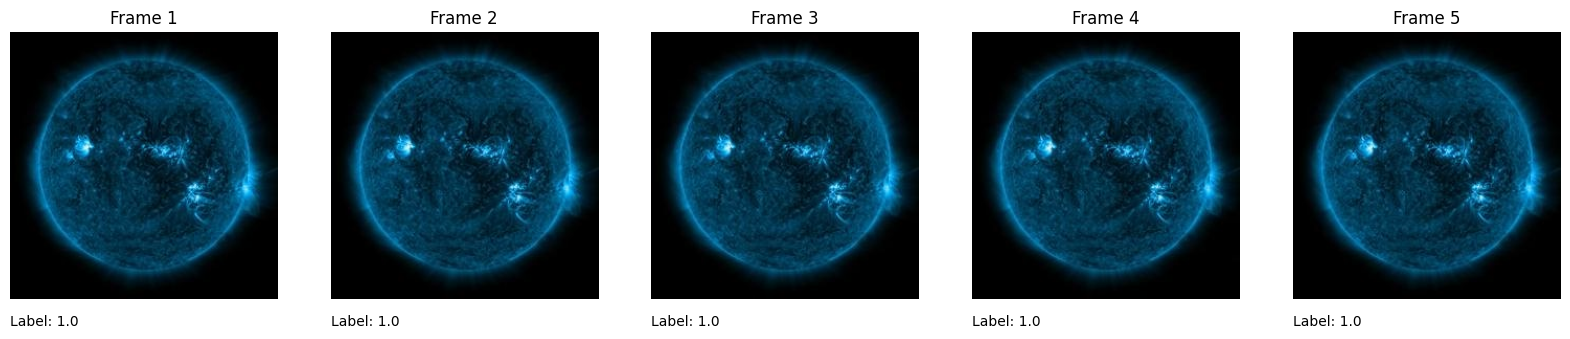

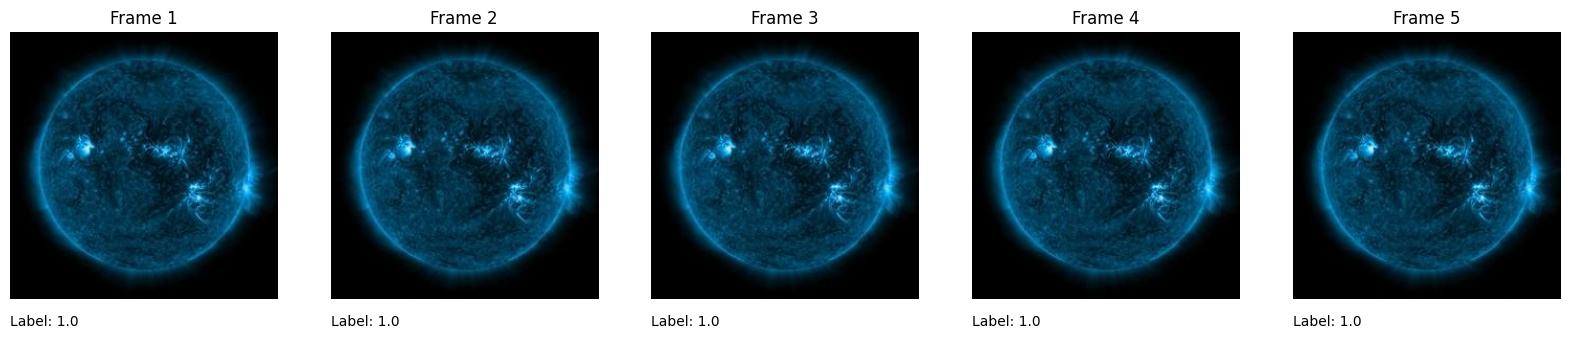

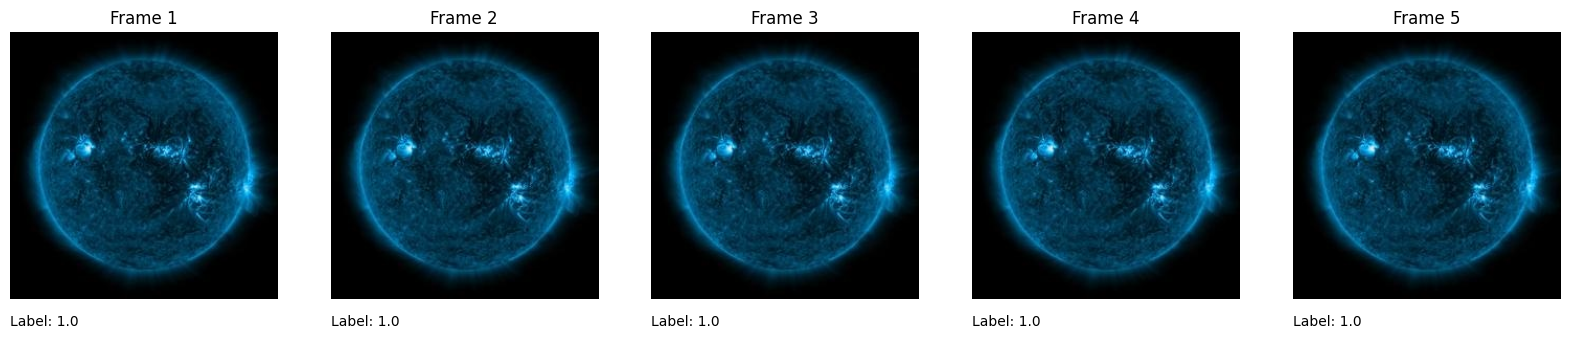

In [183]:
# Display the image sequences
num_series = 3
display_image_sequences(X_test, y_test, time_steps, num_series)

## ConvLSTM Model



### Model Architecture

In [204]:
tf.keras.backend.clear_session()

In [205]:
init_model = Sequential()
# input, with 64 convolutions for 5 images
# that have (time_steps, new_width, new_height, 3) shape
init_model.add(TimeDistributed(Conv2D(64, (5,5), padding='same', activation='relu'), input_shape = (time_steps, new_width, new_height, 3)))
init_model.add(TimeDistributed(Conv2D(64, (5,5), padding='same', activation='relu')))
init_model.add(TimeDistributed(BatchNormalization()))
init_model.add(TimeDistributed(MaxPooling2D()))

init_model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
init_model.add(TimeDistributed(BatchNormalization()))
init_model.add(TimeDistributed(MaxPooling2D()))

init_model.add(TimeDistributed(Conv2D(64, (1,1), padding='same', activation='relu')))
init_model.add(TimeDistributed(BatchNormalization()))
init_model.add(TimeDistributed(MaxPooling2D()))

init_model.add(TimeDistributed(Dropout(0.2)))

# then we can use Flatten to reduce dimension to 1
init_model.add(TimeDistributed(GlobalAveragePooling2D()))

init_model.add(LSTM(256, activation='tanh', return_sequences=False))

init_model.add(Dense(256, activation='relu',  kernel_regularizer =l2(0.001)))
init_model.add(Dropout(.2))
init_model.add(Dense(1, activation='sigmoid'))

* number of filters doesn't seem to have much impact
  * 128 slightly worse than 64 + way longer calc time
* reduction of only two Conv blocks (conv, BN, MP) w 64 filters but reducting the kernel size
  * also the almost the same result (approx 0,39 acc, AUC 0,5)
* only two Conv blocks (conv, BN, MP) w 32 filters, reducting the kernel 5,5 to 3,3 size
  * test acc. 0.3898, AUC 0,5
* increasing the LSTM
  * exact same results ...

* increasing te number of filters from 32 (5,5) to 64 (3,3)
  * again, exact same results ...
* increasing te number of filters from 32 (5,5) to 64 (3,3) + excludiding the class weights
  *

In [206]:
# Compile the model with binary cross-entropy loss
optimizer = keras.optimizers.Adam(0.001)

init_model.compile(
    optimizer,
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [207]:
# Print model summary
init_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 256, 256, 64)   4864      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 256, 256, 64)   102464    
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 256, 256, 64)   256       
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 128, 128, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 128, 128, 64)   3

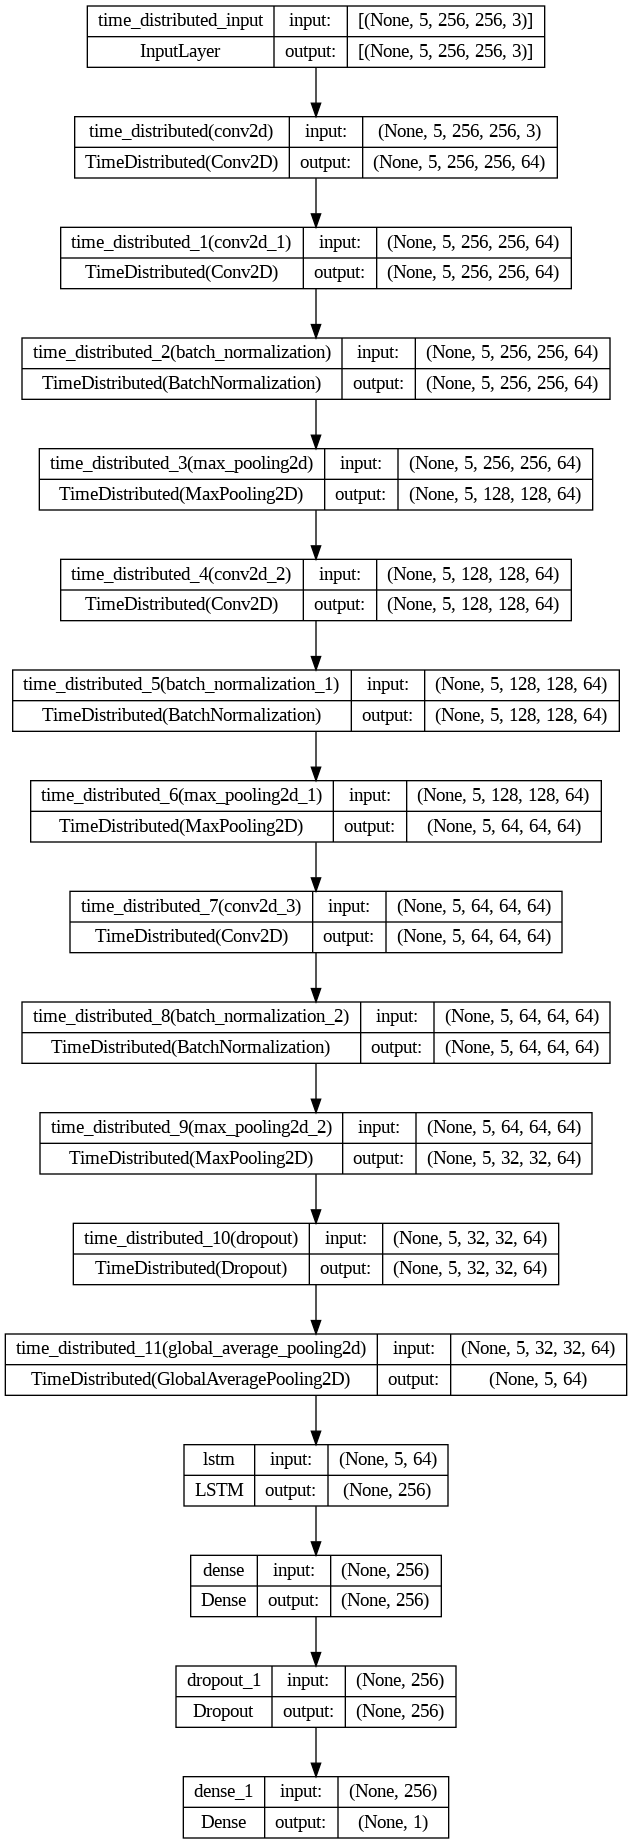

In [209]:
model_dir =  working_dir + '/models'
os.makedirs(model_dir, exist_ok=True)
plot_model(init_model, to_file= model_dir + '/SDO_ConvLSTM_model.png', show_shapes=True, show_layer_names=True)

### Training

In [210]:
# Define the number of epochs and other training parameters
epochs = 15

y_train = np.asarray(y_train ).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
learning_rate=0.001
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

y_train_cw = y_train[:, 0]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_cw), y=y_train_cw)
class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.684931506849315, 1: 1.8518518518518519}

In [211]:
# Train the model
init_history = init_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
75/75 [==============================] - 18s 194ms/step - loss: 0.8582 - accuracy: 0.5883 - val_loss: 0.8505 - val_accuracy: 0.2375 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
75/75 [==============================] - 13s 175ms/step - loss: 0.7599 - accuracy: 0.5400 - val_loss: 1.2036 - val_accuracy: 0.2375 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
75/75 [==============================] - 13s 175ms/step - loss: 0.7151 - accuracy: 0.6800 - val_loss: 2.1305 - val_accuracy: 0.2375 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/15
75/75 [==============================] - 13s 174ms/step - loss: 0.6921 - accuracy: 0.6117 - val_loss: 1.6677 - val_accuracy: 0.2375 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to

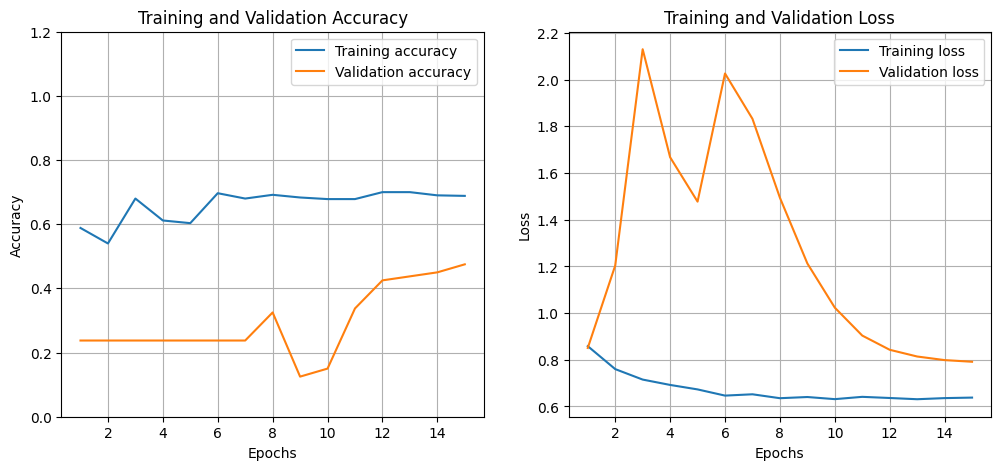

In [212]:
train_loss = init_history.history['loss']
val_loss = init_history.history['val_loss']
train_accuracy = init_history.history['accuracy']
val_accuracy = init_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Accuracy plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.2)  # Set y-axis limits between 0 and 1
plt.grid(True)
plt.legend()

# Loss plots
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

### Evaluation

In [213]:
test_loss, test_accuracy = init_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 1s 100ms/step - loss: 0.7949 - accuracy: 0.5316
Test Loss: 0.7949
Test Accuracy: 0.5316


In [217]:
threshold = 0.3
y_pred = (init_model.predict(X_test) > threshold).astype("int32")

# Flatten y_test and y_pred
y_test_flat = y_test.flatten()
y_pred_flat = y_pred[:, 0]

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test_flat, y_pred_flat))
print("Confusion Matrix:\n", confusion_matrix(y_test_flat, y_pred_flat))

3/3 [==============================] - 0s 120ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.49      0.67      0.57        42
         1.0       0.36      0.22      0.27        37

    accuracy                           0.46        79
   macro avg       0.43      0.44      0.42        79
weighted avg       0.43      0.46      0.43        79

Confusion Matrix:
 [[28 14]
 [29  8]]


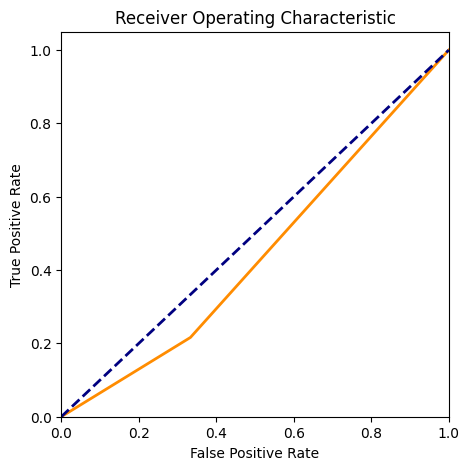

AUC: 0.4414


In [218]:
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_flat)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

# Calculate AUC
auc = roc_auc_score(y_test_flat, y_pred_flat)
print(f"AUC: {auc:.4f}")

## Conclusion

* `drive.flush_and_unmount()` helped to synchronize the and empty Colab's memory.

## Refernces

* https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

* https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f

* https://keras.io/examples/vision/conv_lstm/#data-visualization